# 필수과제 2 설명
- 고객데이터를 올릴 것
- 해당 고객데이터를 기반으로 가설을 세운 후 사용할 컬럼 정리하고
- 해당 컬럼을 기반으로 kmeans를 진행하여서 분석에 대한 인사이트 정리
- 군집에 대해서 몇 개를 선정하는지는 구글링을 통해서 해당 지표도 만들어보기
- 기존에 데이터가 어떤 패턴을 보였고, 우리가 선정한 컬럼을 통해서 만들어진 군집 ( 고객군 ) 어떤 패턴을 보이는지 확인

# 데이터 불러오기

In [1]:
# 나눔고딕 한글폰트 설치 -> 시각화 한글 깨짐 문제 해결
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rc('font', family='NanumBarunGothic') 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/데이터 분석 중급반(6기)/데이터

Mounted at /content/drive
/content/drive/MyDrive/데이터 분석 중급반(6기)/데이터


In [4]:
ct = pd.read_csv("./NH거래고객데이터.csv")
ct.drop('Unnamed: 0', axis = 1,inplace=True)
ct

,계좌,성별,연령구간,투자성향,고객자산구간,주거래상품군,LIFESTAGE,고객등급,총투자기간,주거래업종구분
0,64aae8dd71e5c0761000db9f9a6779e504e7a4aa9dc097...,1,4,99,1,2,3,3,6,16
1,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,1,6,4,4,2,5,2,6,1
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,2,7,4,3,2,5,5,6,9
3,6d497facfa1ea5901b827335553331f8555fec02a8184f...,2,6,4,4,8,5,3,6,16
4,b727c78d2cfc246c97b677f29a034399a0c7e7873fff44...,1,5,2,2,2,5,5,5,16
...,...,...,...,...,...,...,...,...,...,...
9995,2fdd734bf8fc04c0d484ddc1d021622a1cdc802705702e...,1,9,4,2,2,9,5,2,16
9996,720aa28d24bfa8fbeddf4fe625cb53af0a6f7ff2d526de...,2,2,3,1,2,2,9,1,16
9997,7702030b3b0760e6b37c8a3e8ed58611b1b85913526ad1...,2,7,4,2,2,5,5,2,16
9998,4006ddaa5673365096b9dd5965e20db866f6523c162f79...,1,5,99,5,2,5,3,2,5


- 계좌 데이터는 필요없어 보이므로 제외

In [5]:
ct2 = ct.drop('계좌', axis = 1)
ct2.head()

,성별,연령구간,투자성향,고객자산구간,주거래상품군,LIFESTAGE,고객등급,총투자기간,주거래업종구분
0,1,4,99,1,2,3,3,6,16
1,1,6,4,4,2,5,2,6,1
2,2,7,4,3,2,5,5,6,9
3,2,6,4,4,8,5,3,6,16
4,1,5,2,2,2,5,5,5,16


In [6]:
ct2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   성별         10000 non-null  int64
 1   연령구간       10000 non-null  int64
 2   투자성향       10000 non-null  int64
 3   고객자산구간     10000 non-null  int64
 4   주거래상품군     10000 non-null  int64
 5   LIFESTAGE  10000 non-null  int64
 6   고객등급       10000 non-null  int64
 7   총투자기간      10000 non-null  int64
 8   주거래업종구분    10000 non-null  int64
dtypes: int64(9)
memory usage: 703.2 KB


# 시각화

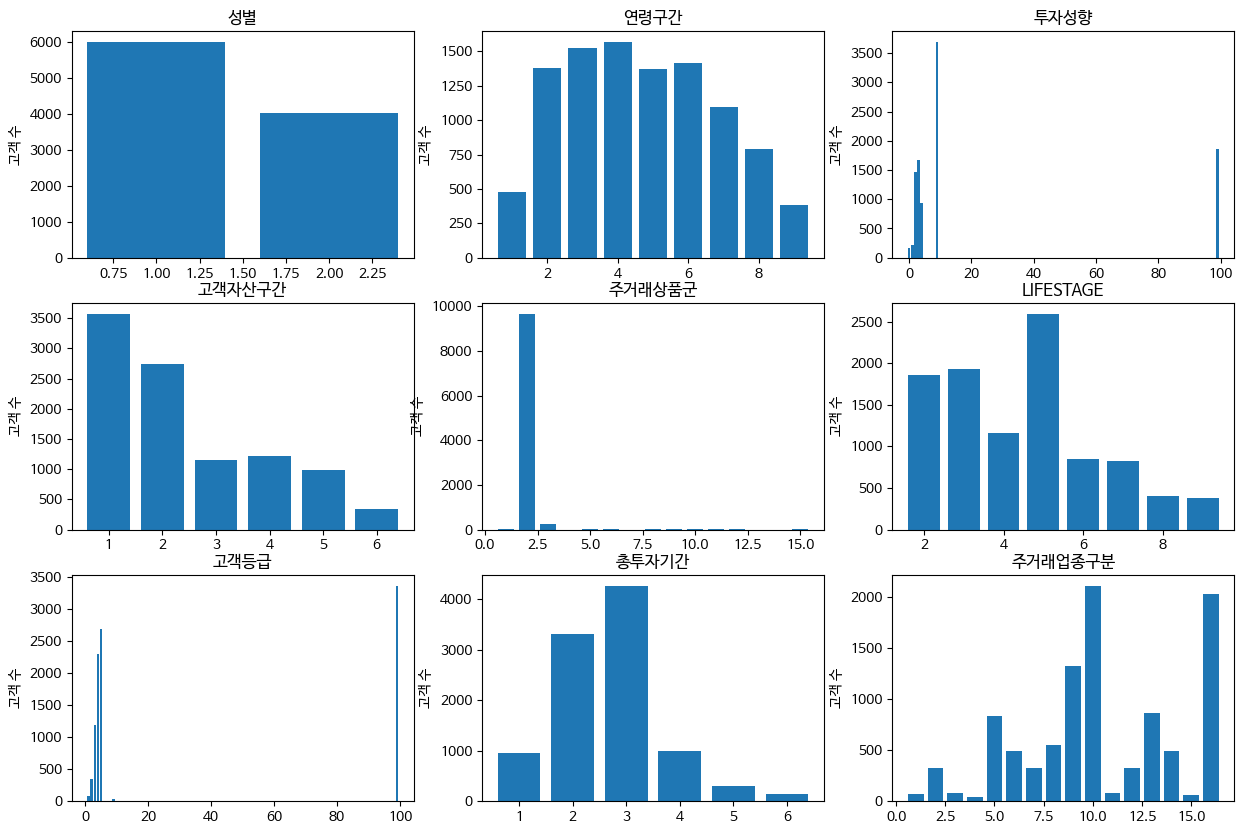

In [7]:
# 고객 등급별 고객의 수 시각화
i = 1
plt.figure(figsize = (15,10))
for col in ct2.columns:
  if i<=9:
    plt.subplot(3,3,i)
    index = list(set(ct2[col]))
    plt.bar(index, ct2.groupby(col)['성별'].count())
    plt.title(col)
    plt.ylabel("고객 수")
    i+=1

plt.show()

# 가설설정
- 각 연령별로 거래나 투자를 하는데 있어서 차이를 보이지 않을까?
- 각 연령별로 가지고 있는 재산이나 환경이 다를 것이기 때문에 투자나 거래하는 종류가 다를 것이라고 생각
- 연령을 나타내는 연령구간, LIFESTAGE와 다른 열들을 비교하여 각 연령별로 나타나는 특징이 있는지 파악해보고자 한다

# 데이터 전처리

- 투자성향과 고객등급에서 이상치로 보이는 데이터가 관측되어 제외(kmeans는 이상치에 취약함)
- 성별도 분석 대상에서 제외
- 또한 데이터간 편차가 심한 주거래상품군, 주거래업종구분도 제외

In [8]:
ct3 = ct2.drop(['성별','투자성향','고객등급', '주거래상품군','주거래업종구분'], axis = 1)
ct3.head()

,연령구간,고객자산구간,LIFESTAGE,총투자기간
0,4,1,3,6
1,6,4,5,6
2,7,3,5,6
3,6,4,5,6
4,5,2,5,5


In [9]:
scaler = StandardScaler()
scaler.fit(ct3)
scaled_ct = scaler.transform(ct3)
scaled_ct

array([[-0.31903503, -0.96562621, -0.76506809,  3.36458866],
       [ 0.61614019,  1.05860594,  0.28117887,  3.36458866],
       [ 1.08372781,  0.38386189,  0.28117887,  3.36458866],
       ...,
       [ 1.08372781, -0.29088216,  0.28117887, -0.69169834],
       [ 0.14855258,  1.73334999,  0.28117887, -0.69169834],
       [ 0.61614019,  1.73334999,  0.28117887,  2.35051691]])

# 최적의 K 선별

## Elbow method
- 최적인 클러스터 개수(K)를 추정
- 뾰족하게 구부러진 부분이나 특정 지점이 팔처럼 굽어지는 부분을 K로 지정 
- k값의 증가 → 센트로이드의 증가 → 데이터들이 센트로이드에 더 가까워짐 → 왜곡값(SSE)의 감소


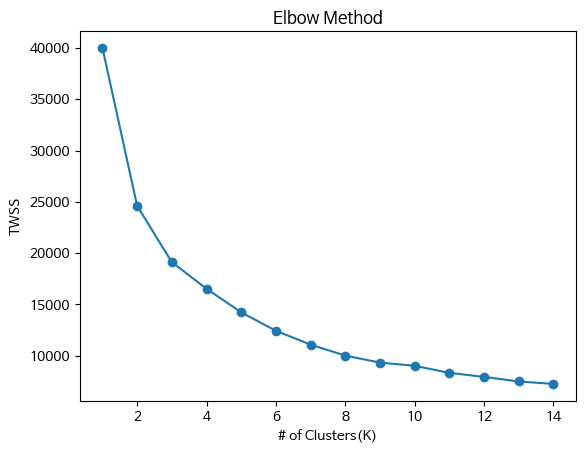

In [10]:
TWSS = {}
for k in range(1,15):
  model = KMeans(n_clusters = k, init = 'k-means++', max_iter = 300, random_state = 111)
  model.fit(scaled_ct)
  TWSS[k] = model.inertia_

plt.plot(list(TWSS.keys()), list(TWSS.values()), marker = 'o')
plt.title("Elbow Method")
plt.xlabel("# of Clusters(K)")
plt.ylabel("TWSS")
plt.show()

## 실루엣 기법 (Silhouette method)
- 실루엣 분석은 각 군집 간의 거리가 얼마나 효율적으로 분리 돼있는지를 나타냄

- 효율적으로 잘 분리 됐다 = 다른 군집과의 거리는 떨어져 있고 동일 군집끼리의 데이터는 서로 가깝게 잘 뭉쳐 있다​
 
- 실루엣 계수 값은 0 ~ 1의 값을 가진다. 
  - 1에 가까울 수록 클러스터의 갯수에 따른 데이터는 군집과 멀리 떨어져 있다는 뜻이고, 0에 가까울수록 근처의 군집과 가깝다는 뜻이다.
  - 실루엣 계수는 1에 가까울수록 최적화가 잘 되어있다라고 판단할 수 있다

In [11]:
def visualize_silhouette_layer(data, param_init = 'k-means++', param_max_iter = 300):
    clusters_range = range(2,15)
    results = []

    for i in clusters_range:
        clusterer = KMeans(n_clusters=i, init=param_init, max_iter=param_max_iter, random_state=111)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.show()

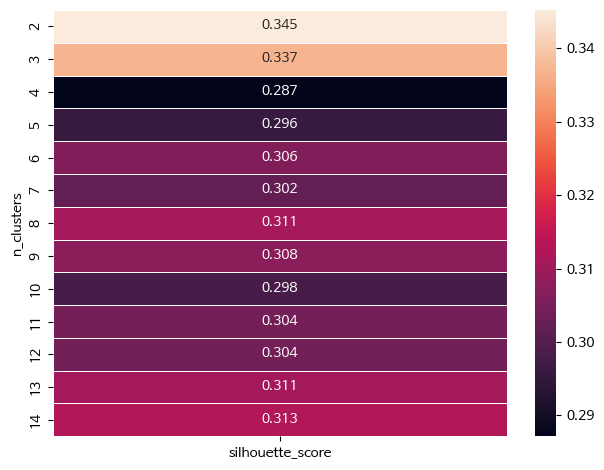

In [12]:
visualize_silhouette_layer(scaled_ct)

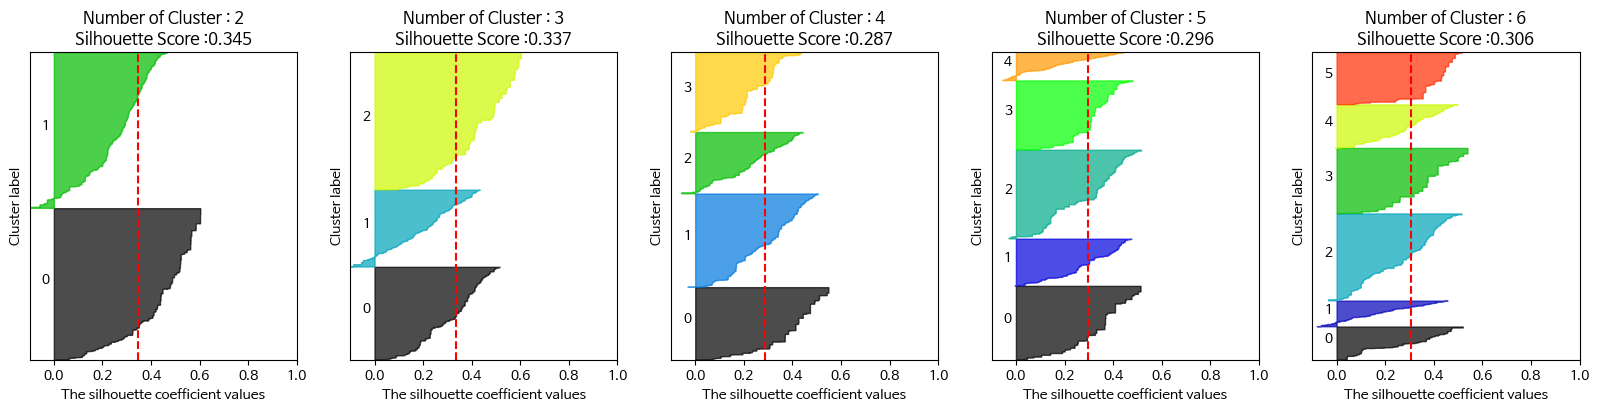

In [13]:
# 실루엣 기법
def visualize_silhouette(cluster_lists, X_features): 

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, init = 'k-means++', max_iter = 300, random_state = 111)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

visualize_silhouette([2, 3, 4, 5, 6], scaled_ct)

- elbow method, silhouette의 결과, K = 2, 3으로 선택하는 것이 좋아보임 

### K=2로 한 경우

In [44]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, random_state=111)
kmeans.fit(scaled_ct)

KMeans(n_clusters=2, random_state=111)

In [45]:
ct3['cluster'] = kmeans.labels_
ct3.head()

,연령구간,고객자산구간,LIFESTAGE,총투자기간,cluster
0,4,1,3,6,0
1,6,4,5,6,1
2,7,3,5,6,1
3,6,4,5,6,1
4,5,2,5,5,1


In [46]:
ct3.groupby("cluster")['연령구간'].value_counts()

cluster  연령구간
0        3       1512
         4       1398
         2       1378
         1        481
         5        128
         6         29
1        6       1386
         5       1241
         7       1098
         8        787
         9        381
         4        169
         3         12
Name: 연령구간, dtype: int64

- 각 군집의 연령구간 확인 결과 
  - 군집 0에는 연령구간이 3,4,2,1,5,6 순으로 주로 젊은층(20~40세)이 주로 분포해 있는 것을 확인 가능
  - 군집 1에는 연령구간이 6,5,7,8,9,4,3 순으로 주로 노인층?(40~65)이 주로 분포해 있음

In [47]:
ct3.groupby("cluster")['고객자산구간'].value_counts()

cluster  고객자산구간
0        1         2359
         2         1465
         3          494
         4          388
         5          203
         6           17
1        2         1275
         1         1213
         4          834
         5          781
         3          653
         6          318
Name: 고객자산구간, dtype: int64

- 각 군집의 고객자산구간 확인 결과
  - 두 군집의 분포가 서로 비슷함을 확인 가능
  - 두개의 군집으로는 어떠한 인사이트를 얻기 힘들어보임. 또한 데이터의 수가 1,2가 다른 구간에 비해서 많기 때문에 이런 결과가 나온 것으로도 생각함

In [48]:
ct3.groupby("cluster")['LIFESTAGE'].value_counts()

cluster  LIFESTAGE
0        2            1860
         3            1854
         4            1055
         5             140
         6              17
1        5            2453
         6             834
         7             827
         8             400
         9             379
         4             109
         3              72
Name: LIFESTAGE, dtype: int64

- 각 군집의 LIFESTAGE 확인 결과
  - 군집 1의 경우 5,6,7,8,9,4,3 순으로 가족성숙기의 사람들이 많이 나타남
  - 군집 0의 경우 2,3,4,5,6 순으로 사회초년생(20-29세), 가족형성기_남녀(30-39세)이상의 사람들이 많이 나타남
  - 연령구간과 비슷한 결과가 나오는 것으로 보임(애초에 두 열이 비슷한 특징을 가진 데이터여서..?)



In [49]:
ct3.groupby("cluster")['총투자기간'].value_counts()

cluster  총투자기간
0        3        1954
         2        1875
         1         756
         4         306
         5          33
         6           2
1        3        2317
         2        1440
         4         686
         5         279
         1         206
         6         146
Name: 총투자기간, dtype: int64

- 각 군집의 총투자기간 확인 결과
  - 군집 0의 경우 3,2,1,4,5,6 순으로 6개월~3년 미만동안 계좌 개설 이래 고객이 100만원 이상 보유한 사람들이 많은 것으로 확인된다. 
  - 군집 1도 마찬가지로 3,2,4,5,1,6 순으로 6개월~3년의 사람들이 많은 것으로 확인된다
  - 총투자기간도 마찬가지로, 2,3에 해당하는 데이터가 다른 기간의 데이터들보다 많아서 그렇게 된 것으로 보임
  - 또한 나머지 기간들에서도 뚜렷한 구분은 보이지 않음

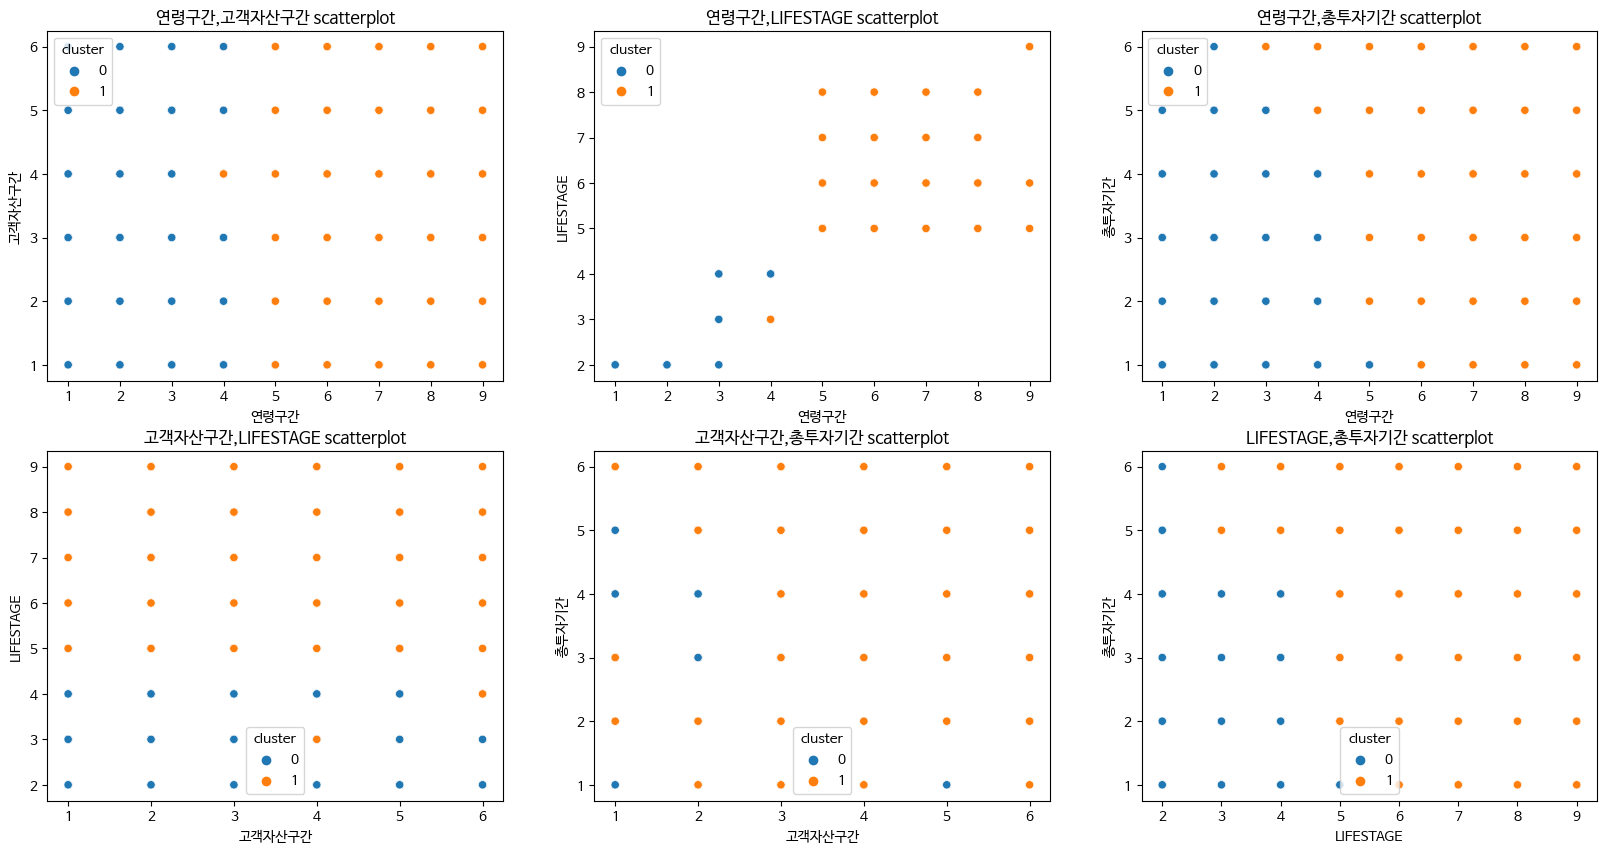

In [50]:
col = ["연령구간", "고객자산구간", "LIFESTAGE", "총투자기간"]
k = 1
plt.figure(figsize = (20,10))
for i in range(0,3):
  for j in range(i+1,4):
    plt.subplot(2,3,k)
    sns.scatterplot(x= col[i], y= col[j], hue="cluster", data=ct3)
    title = col[i] + "," + col[j] + " scatterplot"
    plt.title(title)
    k += 1

### K=3로 한 경우

In [20]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=111)
kmeans.fit(scaled_ct)

KMeans(n_clusters=3, random_state=111)

In [21]:
ct3['cluster'] = kmeans.labels_
ct3.head()

,연령구간,고객자산구간,LIFESTAGE,총투자기간,cluster
0,4,1,3,6,2
1,6,4,5,6,1
2,7,3,5,6,1
3,6,4,5,6,1
4,5,2,5,5,1


In [22]:
ct3.groupby("cluster")['연령구간'].value_counts()

cluster  연령구간
0        6        840
         5        830
         7        658
         8        448
         9        243
1        6        575
         5        539
         7        440
         8        339
         4        337
         9        138
         3        126
         2          9
         1          1
2        3       1398
         2       1369
         4       1230
         1        480
Name: 연령구간, dtype: int64

- 각 군집의 연령구간 확인 결과
  - 군집 0에서는 6,5,7,8,9 순으로 40세 이후의 사람들이 많이 분포해 있음.
  - 군집 1에서는 6,5,7,8,9,3,2,1 순으로 군집0과 마찬가지로 40세 이후의 사람들이 많이 분포해 있음
  - 군집2에서는 3,2,4,1 순으로 40세 미만의 젊은 사람들이 주로 분포해 있음
  - K=2로 설정했을 때보다 40세 이후의 사람들을 두 군집으로 나눠 놓은 듯한 것으로 보임

In [23]:
ct3.groupby("cluster")['고객자산구간'].value_counts()

cluster  고객자산구간
0        1         1360
         2         1214
         3          376
         4           67
         5            2
1        5          926
         4          890
         6          332
         3          285
         2           68
         1            3
2        1         2209
         2         1458
         3          486
         4          265
         5           56
         6            3
Name: 고객자산구간, dtype: int64

- 각 군집을 고객자산구간별로 나눠본 결과
  - 군집 0에서는 고객자산구간이 1,2,3,4,5 순으로 고객자산이 3천만원 미만인 사람들이 많이 분포해 있음
  - 군집 1에서는 고객자산구간이 5,4,6,3,2,1 순으로 고객자산이 5천만원 이상인 사람들이 주로 분포해 있음
  - 군집 2에서는 1,2,3,4,5,6 순으로 군집 0과 마찬가지로 고객자산이 3천만원 미만인 사람들이 많이 분포해 있음
  - K=2로 설정했을 때보다 각 구간별 구분이 더 뚜렷한 것을 확인할 수 있음(?)

In [24]:
ct3.groupby("cluster")['LIFESTAGE'].value_counts()

cluster  LIFESTAGE
0        5            1462
         6             564
         7             468
         8             284
         9             241
1        5            1131
         7             359
         3             298
         6             287
         4             165
         9             138
         8             116
         2              10
2        2            1850
         3            1628
         4             999
Name: LIFESTAGE, dtype: int64

- 각 군집의 LIFESTAGE 확인 결과
  - 군집 0의 경우 5,6,7,8,9 순으로 가족성숙기의 사람들이 많이 나타남
  - 군집 1의 경우 5,7,3,6,4,9,8 순으로 남자 고객들의 분포가 많이 나타남
  - 군집 2의 경우 2,3,4 순으로 사회 초년생(20-29세)이나 가족 형성기 남녀(30-39세)의 사람들이 많이 분포해 있음
  - K=2와 마찬가지로 연령구간과 비슷한 결과가 나오는 것으로 보임(애초에 두 열이 비슷한 특징을 가진 데이터여서..?)
  - K=2일 때보다 오히려 더 군집의 결과가 나빠진 것으로 보임



In [25]:
ct3.groupby("cluster")['총투자기간'].value_counts()

cluster  총투자기간
0        3        1310
         2        1107
         1         283
         4         266
         5          45
         6           8
1        3        1175
         4         488
         2         445
         5         248
         6         138
         1          10
2        3        1786
         2        1763
         1         669
         4         238
         5          19
         6           2
Name: 총투자기간, dtype: int64

- 각 군집의 총투자기간 확인 결과
  - 군집 0의 경우 3,2,1,4,5,6 순으로 6개월~3년 미만동안 계좌 개설 이래 고객이 100만원 이상 보유한 사람들이 많은 것으로 확인된다. 
  - 군집 1도 마찬가지로 3,2,4,5,6,1 순으로 6개월~3년의 사람들이 많은 것으로 확인된다
  - 군집 2는 3,2,1,4,5,6 순으로 위 두 군집과 큰 차이가 없어보인다.
  - K=2일 때와 마찬가지로, 2,3에 해당하는 데이터가 다른 기간의 데이터들보다 많아서 그렇게 된 것으로 보임
  - 또한 나머지 기간들에서도 뚜렷한 구분은 보이지 않음

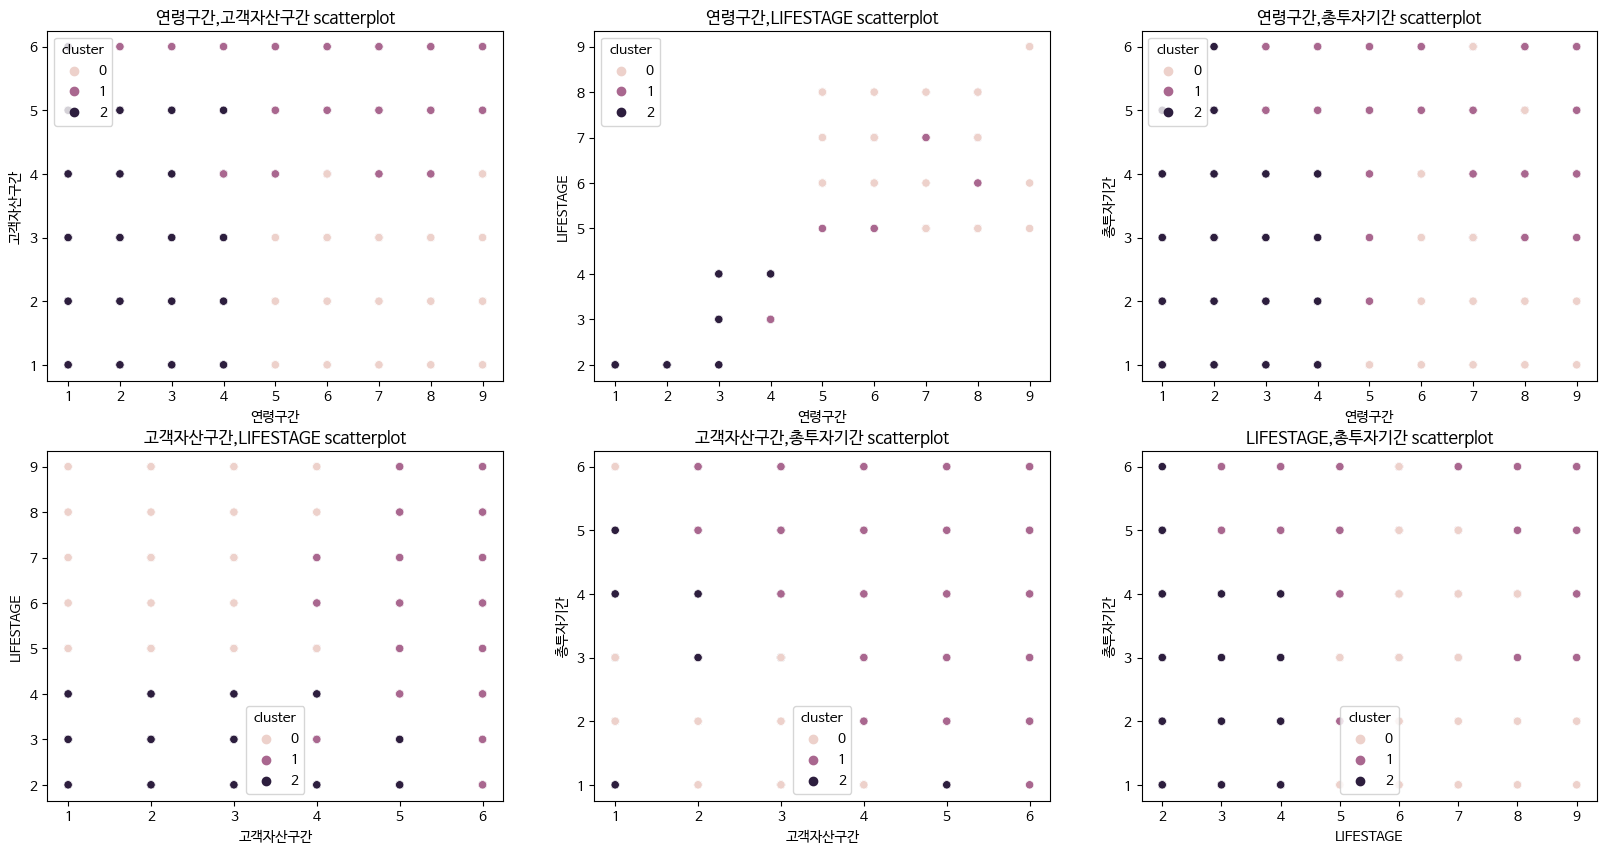

In [43]:
col = ["연령구간", "고객자산구간", "LIFESTAGE", "총투자기간"]
k = 1
plt.figure(figsize = (20,10))
for i in range(0,3):
  for j in range(i+1,4):
    plt.subplot(2,3,k)
    sns.scatterplot(x= col[i], y= col[j], hue="cluster", data=ct3)
    title = col[i] + "," + col[j] + " scatterplot"
    plt.title(title)
    k += 1